In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import required libraries
from skimage.measure import label
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import scipy as sp
from scipy import signal
import bruges
import seismic.additional_functions as seis # library created for the purpose of this lecture series, explore further if interested!

## Practical 1: Synthetic Seismic

### 1.1 Read a `png` as your geological model:
Bellow you can find an example of reading the geometry model from a `.png` format and apply all the procedures in EX1 on it. It is good practice to understand each step taken here so you can learn to deal with different data formats but still achieve the same outcome.

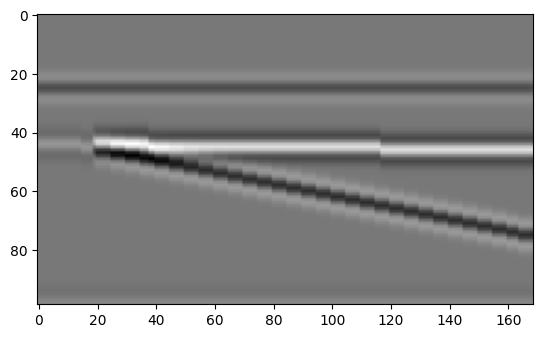

In [3]:
# read in image to numpy array
img = seis.read_img('data/wedge.png', visualise = False) 

# identify each geological section
model_bound = label(img)
# remove imaginary boundary separations seen in img
model = seis.remove_bounds(model_bound, visualise = False) 

# rescale axis to metres
depth = 100
model_scaled = sp.ndimage.zoom(model, 1/(np.shape(model)[0]/depth), order=0)

# set the geological properties for each geological unit
properties = np.array([[2700, 2750],  # [p-wave velocity, density] for layer 1 (index = 0)
                  [2400, 2450],
                  [2600, 2650], 
                  [3500, 2950]])
# bring properties into model
earth = properties[model_scaled] # array shape = rows, cols, properties

# calculate the petrophysical properties for each geological unit 
impedances_1 = np.apply_along_axis(np.product, 2, earth)  #
reflection_coeff_1 = (impedances_1[1:,:] - impedances_1[:-1,:]) / (impedances_1[1:,:] + impedances_1[:-1,:]) 

# generate wavelet
ricker, t = bruges.filters.ricker(duration=0.098, dt=0.002, f=50, return_t = True, sym=False) 
duration = 0.098
dt = 0.002

# convolve
synth = np.array([np.apply_along_axis(lambda t: np.convolve(t, ricker, mode='same'), axis=0,
                             arr= reflection_coeff_1)])
# visualise result
plt.imshow(synth[0], cmap='gray', aspect=1)
plt.show()

### 1.2  What is the unit of acoustic impedance? Does it look familiar to you?

<details>
    <summary>💡 Answer</summary>
$ \frac{Kg}{m ^{2} s}$ . This is similar to the unit of pressure ($ N == Kg \frac{m}{s ^{2}} , Pa == \frac{N}{m^{2}} == \frac{kg}{m s ^{2}}$

So, the unit of acoustic impedance can also be written as:

$$ Pa \frac{s}{m} $$</details>

### 1.3  write your own ricker function and try to see if you can repeat the procedures in Ex1 here

<details>
    <summary>💡 Answer</summary>
<code>    
def ricker(f, duration=0.098, dt=0.002):
    t = np.linspace(-duration/2, (duration-dt)/2, int(duration/dt))
    y = (1-2*(np.pi**2)*(f*2)*(t**2))*np.exp(-(np.pi*2)*(f**2)*(t**2))
    return t, y

f0 = 20 # Dominant frequency of Ricker wavelet (in Hz)
t0=0.8 # Arrival time at zero offset (in s)
t, y = ricker(f0, t0)
plt.plot(t,y)
</code>
</details>

### 1.4 Minimum-phase wavelet and ormsby wavelet 
 design your own version of a minimum-phase wavelet, make sure you can tweak the wavelength (in this notebook it is the proxy to frequency)
 A minimum phase wavelet requires to start at time zero with zero amplitude.

In [4]:
# @hidden
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('.cm-comment:contains(@hidden)').closest('div.input').hide();
 } else {
 $('.cm-comment:contains(@hidden)').closest('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code is hidden so you can give it a try first.
To see the answer, click <a href="javascript:code_toggle()">here</a>.''')

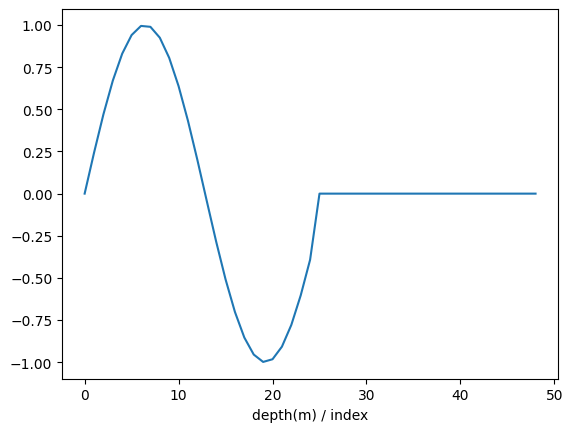

In [5]:
# @hidden

width_inv = 20
t = 1/ width_inv
duration = 0.098
dt = 0.002
time = np.linspace(0,duration, int(duration/dt))

# create your own zero-phase wavelet
zero_phase = np.sin( (width_inv)*6 * time)
zero_phase[np.where(time >= t)[0][0]:] = 0

plt.plot(zero_phase)
plt.xlabel('depth(m) / index')
plt.show()


**Look into the references documentation ([see here](https://bruges.readthedocs.io/api/bruges.filters.wavelets.html)) and create an ormsby wavelet**

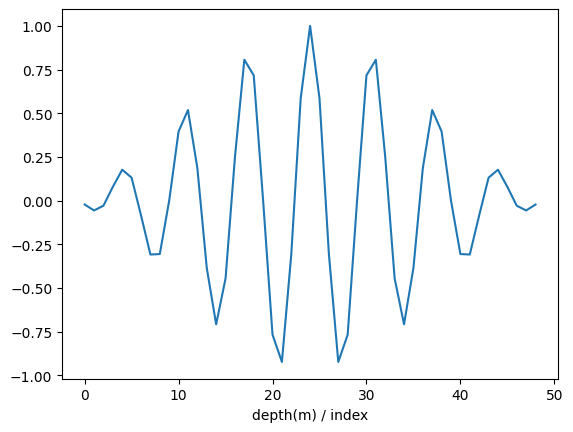

In [6]:
# @hidden
inv_width = [60, 70, 80, 90]
ormsby, t = bruges.filters.wavelets.ormsby(duration=0.098, dt=0.002, f=inv_width, return_t = True, sym=True)
plt.plot(ormsby)
plt.xlabel('depth(m) / index')
plt.show()

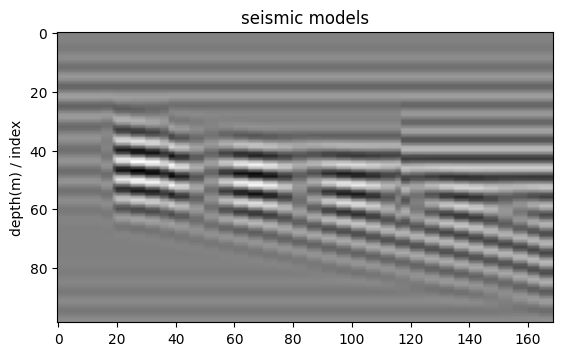

In [7]:
# @hidden

synth_ormsby = np.array([np.apply_along_axis(lambda t: np.convolve(t,ormsby, mode='same'), axis=0,
                             arr= reflection_coeff_1)])

plt.imshow(synth_ormsby[0], cmap='gray', aspect=1)
plt.title('seismic models')
plt.ylabel('depth(m) / index')
plt.show()


### 1.5 Attenuation and noise
### 1.5.1 Spherical divergence

As seismic waves travel their amplitude decrease by 1/r, so the amplitude of reflections is actually lower than predicted in the example above which only considers amplitude changes related to reflection coefficient. One of the relatively early steps in seismic data processing is to remove this affect by doing the reverse of the calculation below. 

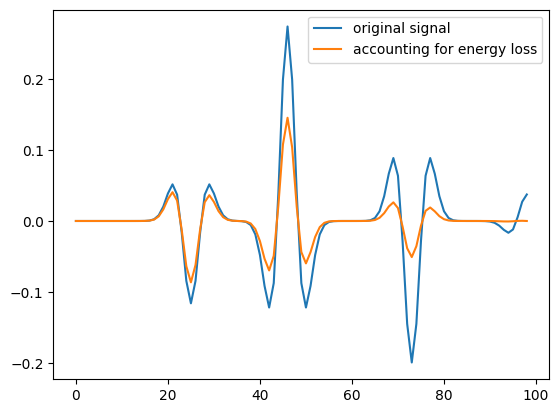

In [8]:
trace_1 = np.shape(impedances_1)[1]-10
out = np.convolve(reflection_coeff_1[:,trace_1], ricker, mode='same') # take/create seismic trace
decay = np.linspace(1,0,len(out)) #linear decay, can vary this if we like
plt.plot(out, label='original signal')
plt.plot(out*decay, label='accounting for energy loss') # apply predicted/alculatecd decay to the trace
plt.legend()
plt.show()

### 1.5.2. Absorption
As seismic waves travel the high-frequency components which have shorter wavelengths are more readily absorbed and scattered. Therefore, as a seismic wave travels it's dominant frequency reduces. This affect is difficult to calculate as it will depend on the properties of the rock. In this example we are using a simple function to simulate frequency decrease with depth. 

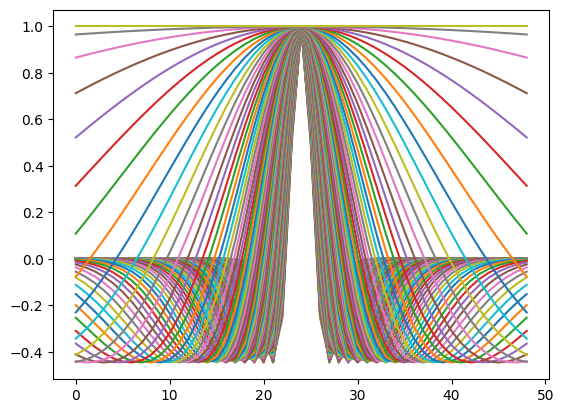

In [9]:
# reducing wavelengths as a function of depth
hz = 70
wave_decay = []
for z in np.linspace(1,0,int(np.shape(reflection_coeff_1)[0])):
    ws, t = bruges.filters.ricker(duration=0.098, dt=0.002, f=hz*z, return_t = True, sym = True);
    wave_decay.append(ws)
    plt.plot(ws)


### 1.5.3 Now we will apply the frequency absorption. For this we want to convolve our wavelet, which now varies as a function of depth, with our traces. Feel free to attempt this yourself first. One method of achieving this is writing our own convolution function

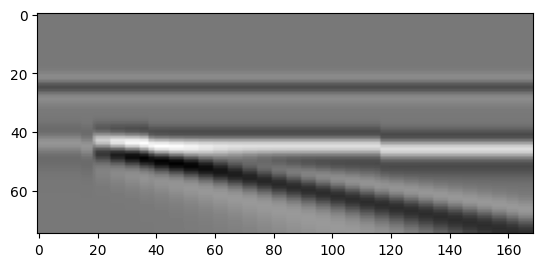

In [10]:
# create zero padding above depth zero of half the kernel size to maintain constant array output size
padding = np.zeros((np.shape(reflection_coeff_1)[0] + int(len(wave_decay[0])/2), np.shape(reflection_coeff_1)[1]))
padding[int(len(wave_decay[0])/2):, :] = reflection_coeff_1
synthetic = []

#create our won convolution function
for trace in range(np.shape(reflection_coeff_1)[1]): #iterate over every trace
    convolved = [] # clean up for each trace
    for depth in range(np.shape(reflection_coeff_1)[0] - int(len(wave_decay[0])/2)): # iterate in depth direction across each trace
        inv_kernel = wave_decay[depth] # no need to inverse arr[::-1] as its symmetric
        convolved.append(np.sum(padding[depth: depth+len(inv_kernel), trace] * inv_kernel))
    synthetic.append(convolved)
    
#make into array
synthetic = np.array(synthetic)

plt.imshow(synthetic.T, cmap = 'gray')

### 1.6. Noise

In addition to the factors above incoherent noise ($N(z)$) will inevitably exist in seismic reflection images even after processing. Here we add incoherent noise to add realism to the seismic section. 

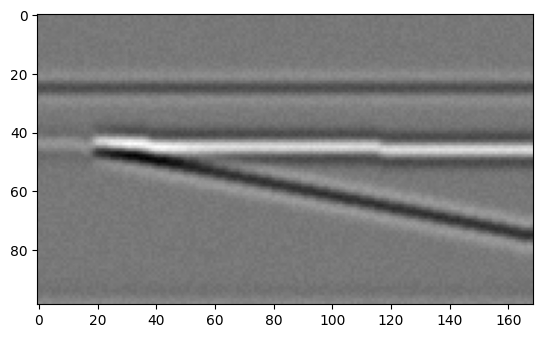

In [11]:
blurred = sp.ndimage.gaussian_filter(synth, sigma=1.1)
noisy = blurred + 0.5 * blurred.std() * np.random.random(blurred.shape)

#show
plt.imshow(noisy[0], cmap='gray', aspect=1)

The main take away you want to have from this section is the appreciation that even our idealised data quickly becomes very complicated to deconvolve and extract our original Earth model from.